In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import cupy as cp

In [1]:
# import logging
# import numpy as np
# import pandas as pd
# import cupy as cp # Use CuPy instead of NumPy

# class PolyRegression:
#     def __init__(self, train_inputs, train_outputs, degree):
#         self.train_inputs = cp.array(train_inputs) 
#         self.train_outputs = cp.array(train_outputs).reshape(-1, 1) # Ensure correct shape
#         self.degree = degree
#         self.weights = cp.random.randn(train_inputs.shape[1] * self.degree + 1, 1)  # Initialize weights randomly
#         self.bias = cp.zeros((1,))
#         self.loss = []
#         self.lambda_reg = 0.1  # Add regularization strength

#     def cost_func(self, prediction, train_output): 
#         return cp.mean((prediction - train_output) ** 2) + \
#                (self.lambda_reg * cp.sum(self.weights ** 2))  # L2 regularization

#     def transform_inputs(self, inputs):
#         transformed_inputs = inputs
#         for i in range(2, self.degree + 1):
#             transformed_inputs = cp.concatenate((transformed_inputs, inputs ** i), axis=1)
#         transformed_inputs = cp.concatenate((cp.ones((transformed_inputs.shape[0], 1)), transformed_inputs), axis=1)
#         return transformed_inputs

#     def normalize_inputs(self, inputs):
#         mean = cp.mean(inputs, axis=0)
#         std = cp.std(inputs, axis=0)
#         std[std == 0] = 1  # Prevent division by zero
#         return (inputs - mean) / std

#     def forward_propagation(self, inputs):
#         return cp.dot(inputs, self.weights) + self.bias

#     def update_weights(self, prediction, train_output, normalized_inputs, learning_rate, momentum=0.9):
#         batch_size = normalized_inputs.shape[0]

#         gradient_weights = (cp.dot(normalized_inputs.T, (prediction - train_output)) / batch_size + 
#                            2 * self.lambda_reg * self.weights)  # Add regularization derivative
#         gradient_bias = cp.mean(prediction - train_output)

#         if not hasattr(self, 'velocity_weights'):
#             self.velocity_weights = cp.zeros_like(self.weights)
#         if not hasattr(self, 'velocity_bias'):
#             self.velocity_bias = cp.zeros_like(self.bias)

#         self.velocity_weights = (momentum * self.velocity_weights + learning_rate * gradient_weights)
#         self.velocity_bias = (momentum * self.velocity_bias + learning_rate * gradient_bias)

#         self.weights -= self.velocity_weights
#         self.bias -= self.velocity_bias

#     def train(self, learning_rate, iters):
#         # Normalize BEFORE transformation
#         normalized_inputs = self.normalize_inputs(self.train_inputs)
#         transformed_inputs = self.transform_inputs(normalized_inputs) 

#         print(f"Initial shapes - train_inputs: {transformed_inputs.shape}, train_outputs: {self.train_outputs.shape}")

#         for i in range(iters):
#             prediction = self.forward_propagation(transformed_inputs)
#             cost = self.cost_func(prediction, self.train_outputs)
#             self.update_weights(prediction, self.train_outputs, transformed_inputs, learning_rate)
#             self.loss.append(cost.get()) 
#             if i % 100 == 0:
#                 print(f"Iteration {i}, cost={cost}")

#         return self.weights, self.bias, self.loss 

#     # ... rest of your code ...

#     def predict(self, test_input):
#         test_input = cp.array(test_input)  # Move data to GPU
#         transformed_inputs = self.transform_inputs(test_input)
#         normalized_inputs = self.normalize_inputs(transformed_inputs)
#         return cp.dot(normalized_inputs, self.weights) + self.bias

#     def accuracy(self, test_input, test_output):
#         prediction = self.predict(test_input)
#         return 1 - self.cost_func(prediction, cp.array(test_output)).get() / cp.mean(cp.array(test_output) ** 2).get()

In [18]:
import logging
import numpy as np
import pandas as pd
import cupy as cp  # Use CuPy instead of NumPy 

class PolyRegression():
    def __init__(self, train_inputs, train_outputs, degree):
        self.train_inputs = cp.array(train_inputs)  # Move data to GPU
        self.train_outputs = cp.array(train_outputs) # Move data to GPU
        self.degree = degree
        self.weights = cp.zeros((train_inputs.shape[1] * self.degree + 1, 1))
        self.bias = 0
        self.loss = []

    def cost_func(self, prediction, train_output, lambda_reg=0.1): 
        return cp.mean((prediction - train_output) ** 2) + \
               (lambda_reg * cp.sum(cp.abs(self.weights)))

    def transform_inputs(self, inputs):
        transformed_inputs = inputs
        for i in range(2, self.degree + 1):
            transformed_inputs = cp.concatenate((transformed_inputs, inputs ** i), axis=1)
        transformed_inputs = cp.concatenate((cp.ones((transformed_inputs.shape[0], 1)), transformed_inputs), axis=1)
        return transformed_inputs

    def normalize_inputs(self, inputs):
        mean = cp.mean(inputs, axis=0)
        std = cp.std(inputs, axis=0)
        std[std == 0] = 1
        return (inputs - mean) / std

    def forward_propagation(self, inputs):
        return cp.dot(inputs, self.weights) + self.bias

    def update_weights(self, prediction, train_output, normalized_inputs, learning_rate):
        prediction = prediction.reshape(-1, 1)
        train_output = train_output.reshape(-1, 1)

        gradient_weights = cp.dot(normalized_inputs.T, (prediction - train_output)) / normalized_inputs.shape[0]
        gradient_bias = cp.mean(prediction - train_output)

        self.weights -= learning_rate * gradient_weights
        self.bias -= learning_rate * gradient_bias

    def train(self, learning_rate, iters):
        print(f"Initial shapes - train_inputs: {self.train_inputs.shape}, train_outputs: {self.train_outputs.shape}")

        transformed_inputs = self.transform_inputs(self.train_inputs)
        normalized_inputs = self.normalize_inputs(transformed_inputs)

        for i in range(iters):
            prediction = self.forward_propagation(normalized_inputs)
            cost = self.cost_func(prediction, self.train_outputs)
            self.update_weights(prediction, self.train_outputs, normalized_inputs, learning_rate)
            self.loss.append(cost.get())  # Retrieve cost from GPU to CPU for logging
            if i % 10000 == 0:
                print(f"Iteration {i}, cost={cost}")

        return self.weights, self.bias, self.loss 

    def predict(self, test_input):
        test_input = cp.array(test_input)  # Move data to GPU
        transformed_inputs = self.transform_inputs(test_input)
        normalized_inputs = self.normalize_inputs(transformed_inputs)
        return cp.dot(normalized_inputs, self.weights) + self.bias

    def accuracy(self, test_input, test_output):
        prediction = self.predict(test_input)
        return 1 - self.cost_func(prediction, cp.array(test_output)).get() / cp.mean(cp.array(test_output) ** 2).get()

In [2]:
import cupy as cp  # Import CuPy instead of NumPy
import pandas as pd
import logging

import matplotlib.pyplot as plt

class LinearRegression:
    def __init__(self, train_inputs, train_outputs):
        self.train_inputs = cp.array(train_inputs)
        self.train_outputs = cp.array(train_outputs).reshape(-1, 1)
        self.weights = cp.zeros((train_inputs.shape[1], 1))
        self.bias = 0
        self.loss = []

    def cost_func(self, prediction, train_output):
        return cp.mean((prediction - train_output) ** 2)

    def sgd(self, prediction, train_output):
        prediction = prediction.reshape(-1, 1)
        train_output = train_output.reshape(-1, 1)
        gradient_weights = cp.dot(self.train_inputs.T, (prediction - train_output)) / self.train_inputs.shape[0]
        gradient_bias = cp.mean(prediction - train_output)
        return gradient_weights, gradient_bias

    def forward_propagation(self):
        return cp.dot(self.train_inputs, self.weights) + self.bias

    def update_weights(self, prediction, train_output, learning_rate):
        gradient_weights, gradient_bias = self.sgd(prediction, train_output)
        self.weights -= learning_rate * gradient_weights
        self.bias -= learning_rate * gradient_bias

    def train(self, learning_rate, iters, log_of_epoch):
        for i in range(iters):
            prediction = self.forward_propagation()
            cost = self.cost_func(prediction, self.train_outputs)
            self.update_weights(prediction, self.train_outputs, learning_rate)
            
            if i % log_of_epoch == 0:
                self.loss.append(cost.get())  # Get cost from GPU
                print(f"Iteration {i}, cost={cost}")

        # Plotting after training (not animated)
        if self.train_inputs.shape[1] == 1:
            plt.figure() 
            plt.scatter(self.train_inputs.get(), self.train_outputs.get(), label='Training data')
            plt.plot(self.train_inputs.get(), self.forward_propagation().get(), color='red', label='Fit')
            plt.xlabel('Input')
            plt.ylabel('Output')
            plt.title('Linear Regression')
            plt.legend()
            plt.show()
        else:
            plt.figure()
            plt.plot(range(len(self.loss)), self.loss, color='red', label='Cost')
            plt.xlabel('Iteration')
            plt.ylabel('Cost')
            plt.title('Cost Function Convergence')
            plt.legend()
            plt.show()

        return self.weights, self.bias, self.loss

    def predict(self, test_input):
        test_input = cp.array(test_input)
        return cp.dot(test_input, self.weights) + self.bias

    def accuracy(self, test_input, test_output):
        prediction = self.predict(test_input)

        # Transfer prediction and test_output to CPU (NumPy) for compatibility:
        prediction_cpu = cp.asnumpy(prediction) 
        test_output_cpu = cp.asnumpy(test_output) 

        # Perform the calculation using NumPy:
        return 1 - self.cost_func(prediction_cpu, test_output_cpu) / np.mean(test_output_cpu ** 2)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data

data = pd.read_csv('/kaggle/input/houseprice/data_cleaned.csv')

data.head()

,city,district,neighborhood,room,living_room,area,age,floor,price
0,afyonkarahisar,merkez,hasan_karaagac,1,1,48,2,-1,8500
1,afyonkarahisar,merkez,yenice,3,1,130,10,5,15000
2,afyonkarahisar,merkez,erenler,1,1,70,5,3,5000
3,afyonkarahisar,merkez,ali_ihsan_pasa,2,1,120,20,5,7000
4,afyonkarahisar,merkez,fatih,3,1,130,1,2,15000


In [4]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
data['city'] = le.fit_transform(data['city'])
data['district'] = le.fit_transform(data['district'])
data['neighborhood'] = le.fit_transform(data['neighborhood'])

# Print the final dataframe
print("\nData after converting categorical columns to numerical:")
print(data)


Data after converting categorical columns to numerical:
      city  district  neighborhood  room  living_room  area  age  floor  price
0        0        46           305     1            1    48    2     -1   8500
1        0        46           652     3            1   130   10      5  15000
2        0        46           201     1            1    70    5      3   5000
3        0        46            44     2            1   120   20      5   7000
4        0        46           224     3            1   130    1      2  15000
...    ...       ...           ...   ...          ...   ...  ...    ...    ...
6111     5        45            93     3            1   155   10      1  17000
6112     5        52           289     3            1   151   10      2  16000
6113     5        67           250     3            1   130   20      2  20500
6114     5         8           589     3            1   130   12      2  35000
6115     5         8           130     2            1    90   31      0  3

In [5]:
# Split the data into training and testing sets

train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Split the data into features and target

X_train = train_data.drop('price', axis=1)
y_train = train_data['price']

X_test = test_data.drop('price', axis=1)
y_test = test_data['price']

In [6]:
x_Train = X_train.shape
x_Test = X_test.shape

In [7]:
x_Train[0]

4893

In [8]:
# turn the data into numpy arrays

X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values



In [9]:
X_train = np.array(X_train).reshape(x_Train[0], 8)
y_train = np.array(y_train).reshape(x_Train[0], 1)

X_test = np.array(X_test).reshape(x_Test[0], 8)  
y_test = np.array(y_test).reshape(x_Test[0], 1)

Iteration 0, cost=440550130.888412
Iteration 1000, cost=96029060.31615745
Iteration 2000, cost=95089566.98306024
Iteration 3000, cost=94231922.18281522
Iteration 4000, cost=93422625.80347073
Iteration 5000, cost=92655725.77988873
Iteration 6000, cost=91928596.15626077
Iteration 7000, cost=91239113.49865822
Iteration 8000, cost=90585309.65532796
Iteration 9000, cost=89965324.73951958
Iteration 10000, cost=89377396.7422678
Iteration 11000, cost=88819855.8293867
Iteration 12000, cost=88291119.43969573
Iteration 13000, cost=87789687.7017551
Iteration 14000, cost=87314139.09895097
Iteration 15000, cost=86863126.36336876
Iteration 16000, cost=86435372.58560733
Iteration 17000, cost=86029667.52905393
Iteration 18000, cost=85644864.13783026
Iteration 19000, cost=85279875.22820087
Iteration 20000, cost=84933670.35377629
Iteration 21000, cost=84605272.8353528
Iteration 22000, cost=84293756.94671734
Iteration 23000, cost=83998245.24820183
Iteration 24000, cost=83717906.06020626
Iteration 25000, c

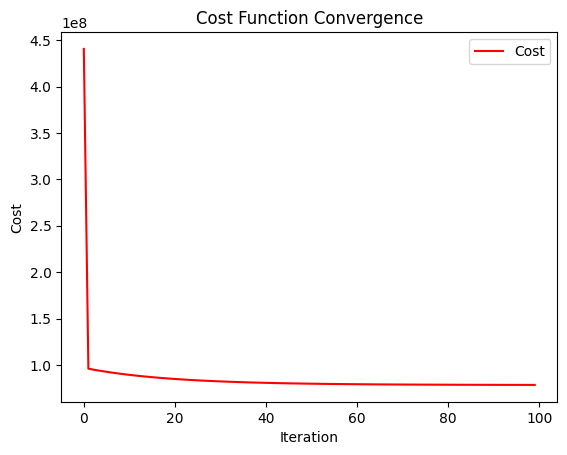

Accuracy: 0.8207196492770256
[[  0  46  44   2   1 120  20   5]] [[7000]]
[[10329.40664531]]


In [14]:
model = LinearRegression(X_train, y_train)

parameters, bias, loss = model.train(learning_rate=0.00001, iters=100000, log_of_epoch = 1000)

accuracy = model.accuracy(X_test, y_test)

print(f'Accuracy: {accuracy}')

print(X_test[0:1], y_test[0:1])
print(model.predict(X_test[0:1]))

In [15]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def tolerance_r2(y_true, y_pred, tolerance):
    residuals = y_pred - y_true
    residuals[np.abs(residuals) <= tolerance] = 0
    ssr = np.sum(residuals**2)
    sst = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ssr / sst)

def tolerance_percentage_r2(y_true, y_pred, tolerance):
    residuals = y_pred - y_true
    residuals[(np.abs(residuals) / y_true) <= tolerance] = 0
    ssr = np.sum(residuals**2)
    sst = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ssr / sst)


In [16]:
y_pred = model.predict(X_test)

# Transfer CuPy arrays to NumPy arrays:
y_test_np = cp.asnumpy(y_test) 
y_pred_np = cp.asnumpy(y_pred)

# Now use the NumPy arrays with scikit-learn:
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}") 

Mean Squared Error (MSE): 75554547.41876088
Root Mean Squared Error (RMSE): 8692.211882988178
R-squared: 0.2629747943156371


In [56]:
from sklearn.linear_model import LinearRegression

# Create an instance of the LinearRegression class
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = model.score(X_test, y_test)

print(f'Accuracy: {accuracy}')


Accuracy: 0.2813757880159211


In [57]:
y_pred = model.predict(X_test)

# Transfer CuPy arrays to NumPy arrays:
y_test_np = cp.asnumpy(y_test) 
y_pred_np = cp.asnumpy(y_pred)

# Now use the NumPy arrays with scikit-learn:
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}") 

Mean Squared Error (MSE): 73668209.2849253
Root Mean Squared Error (RMSE): 8583.018658078596
R-squared: 0.2813757880159211


In [60]:
print(r2_score(y_test, y_pred))
print(tolerance_r2(y_test, y_pred, 10000))
print(tolerance_percentage_r2(y_test, y_pred, 0.50))

0.2813757880159211
0.45752853926075376
0.5274275208782607
